# PINN for noisy aliased data

In [80]:
using Random, LinearAlgebra, DifferentialEquations, ApproxFun
using Plots, ChainPlots, LaTeXStrings, ProgressMeter

In [50]:
using Flux
using Flux.Losses: mse
using Flux.Data: DataLoader
using Flux.Optimise: train!

In this notebook, let's recreate the PINN example that learns the spring-mass dynamics despite only given sparse, noisy data at inopportune intervals.

In [51]:
function spring!(du,u,ℳ,t)
    x,ẋ = u

    du[1] = ∂ₜx = ẋ
    du[2] = ∂ₜẋ = (-ℳ.k*x + 0.1sin(x))/ℳ.m
end

spring! (generic function with 1 method)

In [52]:
m = 1.0
k = 1.0
ℳ = (m=m,k=k)
t0,tf = 0.0,10.0
x0,ẋ0 = 0.0,1.0

(0.0, 1.0)

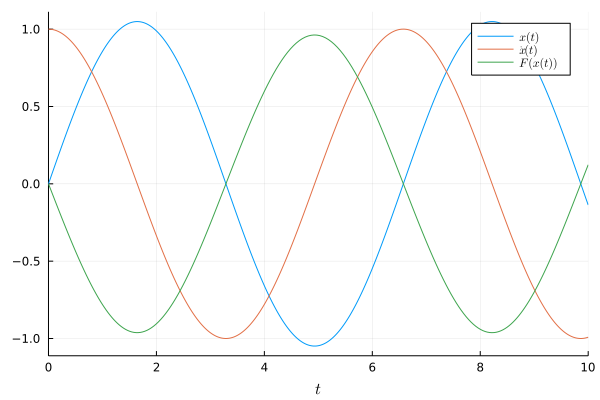

In [53]:
ode = ODEProblem(spring!,[x0,ẋ0],(t0,tf),ℳ)
u = solve(ode)

𝕋 = Chebyshev(t0..tf)
t = points(𝕋,length(u))
x = Fun(𝕋,ApproxFun.transform(𝕋,getindex.(u(t).u,1)))
F(x,ℳ) = -ℳ.k*x + 0.1sin(x)
Fx = F(x,ℳ)

fig = plot(u,xlabel=L"t",label=[L"x(t)" L"\dot x(t)"])
fig = plot!(Fx,label=L"F(x(t))")

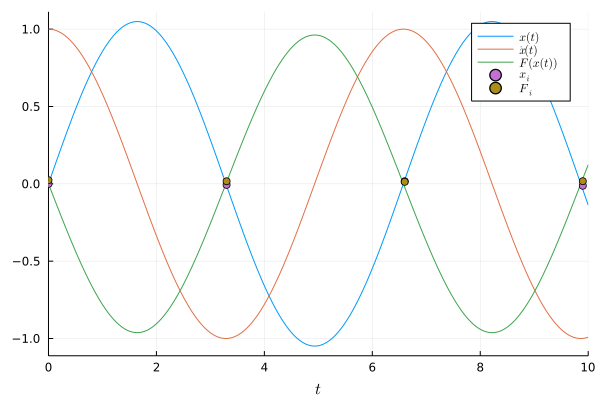

In [232]:
Random.seed!(1)
t = t0:3.3:tf
N = length(t)
ξx = 0.01randn(N)
ξF = 0.02randn(N)
xi = x.(t) + ξx
Fi = Fx.(t) + ξF 

fig = plot(u,xlabel=L"t",label=[L"x(t)" L"\dot x(t)"])
fig = plot!(F(x,ℳ),label=L"F(x(t))")
fig = scatter!(t,xi,label=L"x_i")
fig = scatter!(t,Fi,label=L"F_i")

In [62]:
ℒ₁(f,x,y) = mse(f.(x),y)

ℒ₁ (generic function with 1 method)

In [107]:
η = 0.01
𝒪 = Descent(η)

Descent(0.01)

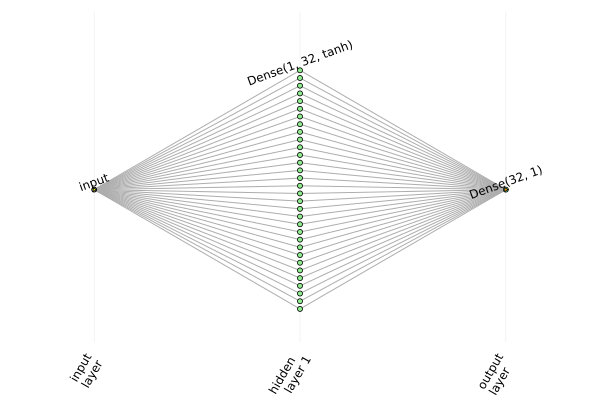

In [233]:
Random.seed!(2)
𝒩 = Chain(Dense(1,32,tanh),Dense(32,1))

fig = plot(𝒩)

In [234]:
𝒩 = Chain(x->[x],𝒩...,y->y[1])
θ = params(𝒩)

Params([Float32[0.2525605; 0.3401842; … ; -0.23628105; 0.38598707;;], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.20599914 0.015782826 … -0.13090308 0.22580218], Float32[0.0]])

In [235]:
Random.seed!(3)

M = 5000
pm = Progress(M)
𝒟 = DataLoader((xi,Fi),batchsize=N)
for m ∈ 1:M
    train!((x,y)->ℒ₁(𝒩,x,y),θ,𝒟,𝒪)
    next!(pm)
end
F̂₁ = Chain(𝒩...)
F̂₁x = F̂₁(x)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27m


Fun(Chebyshev(0.0..10.0),[-0.026095442440348823, 0.006817835563042489, -0.04310430891198114, 0.0091933172775593, 0.1309562162864729, -0.00520249891354285, -0.037523339198877535, 0.0009763206273775897, 0.005105271236668122, -0.00014545202252828383  …  7.755026573559932e-28, -7.027771876189158e-27, -1.1265719290530585e-27, 1.1973424389372739e-27, 6.749523546945318e-28, 3.473648663141576e-28, -3.4732300540299534e-28, -4.80065580479279e-28, 1.0328249529081434e-28, -2.6072356632670276e-28])

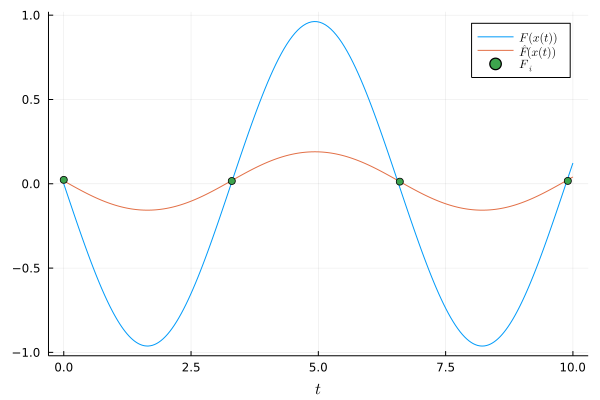

In [236]:
fig = plot(Fx,xlabel=L"t",label=L"F(x(t))")
fig = plot!(F̂₁x,label=L"\hat F(x(t))")
fig = scatter!(t,Fi,label=L"F_i")

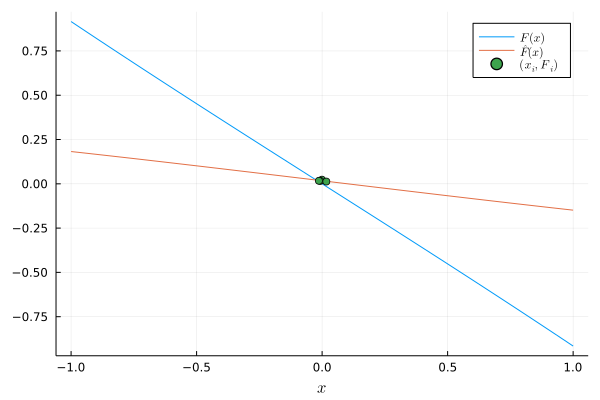

In [237]:
X = -1:0.01:1
fig = plot(X,F.(X,Ref(ℳ)),xlabel=L"x",label=L"F(x)")
fig = plot!(X,F̂₁.(X),label=L"\hat F(x)")
fig = scatter!(xi,Fi,label=L"(x_i,F_i)")

In [114]:
function linear!(du,u,ℳ,t)
    x,ẋ = u

    du[1] = ∂ₜx = ẋ
    du[2] = ∂ₜẋ = -ℳ.k*x/ℳ.m
end

linear! (generic function with 1 method)

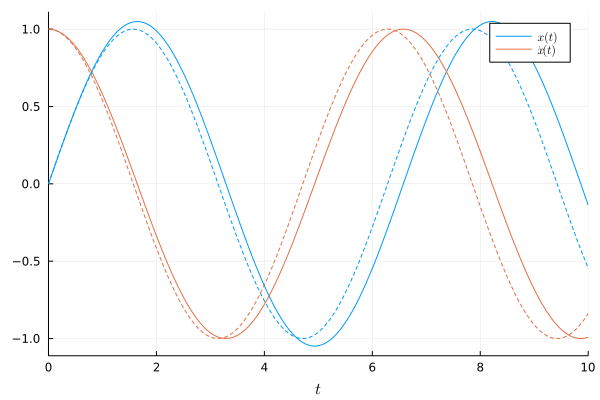

In [211]:
ū = solve(ODEProblem(linear!,[x0,ẋ0],(t0,tf),ℳ))

fig = plot(u,label=[L"x(t)" L"\dot x(t)"])
color = palette(:default)[1:2]'
fig = plot!(ū,xlabel=L"t",style=:dash,color=color,label=false)

In [99]:
ℒ₂(f,x,ℳ) = mse(f.(x),-ℳ.k*x)

ℒ₂ (generic function with 1 method)

In [212]:
ℒ(f,x,y,z,ℳ,λ) = ℒ₁(f,x,y) + λ*ℒ₂(f,z,ℳ)

ℒ (generic function with 2 methods)

In [245]:
Random.seed!(4)
z = 2rand(100).-1
λ = 0.05

0.05

In [246]:
Random.seed!(5)

𝒩 = Chain(x->[x],Dense(1,32,tanh),Dense(32,1),y->y[1])
θ = params(𝒩)
pm = Progress(M)
for m ∈ 1:M
    train!((x,y)->ℒ(𝒩,x,y,z,ℳ,λ),θ,𝒟,𝒪)
    next!(pm)
end
F̂ = Chain(𝒩...)
F̂x = F̂(x)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


Fun(Chebyshev(0.0..10.0),[-0.240615100195683, 0.04083273339591336, -0.2562838008425825, 0.05495492374145061, 0.7727966078972072, -0.029996941499625854, -0.21938259577310476, 0.006125109553298405, 0.03425043620362769, -0.0014121467922922843  …  1.9061108821496747e-25, 5.20043238803476e-25, -3.235223726357212e-26, -1.8141605663204275e-25, -1.6727580933838457e-26, 3.143721737229172e-26, 1.797856484265616e-26, 1.3790016904853362e-26, -1.069352210671122e-26, 1.4311296688705404e-26])

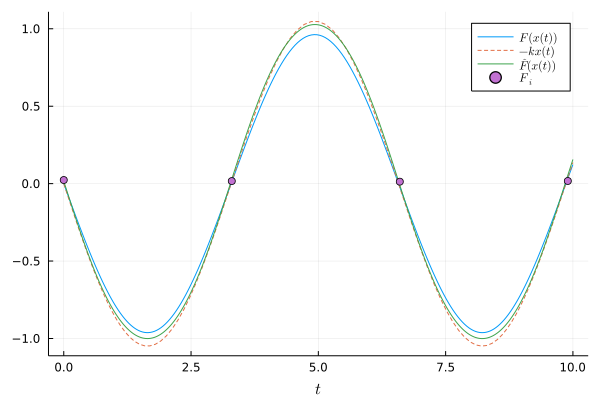

In [247]:
fig = plot(Fx,xlabel=L"t",label=L"F(x(t))")
fig = plot!(-k*x,style=:dash,label=L"-kx(t)")
fig = plot!(F̂x,label=L"\hat F(x(t))")
fig = scatter!(t,Fi,label=L"F_i")

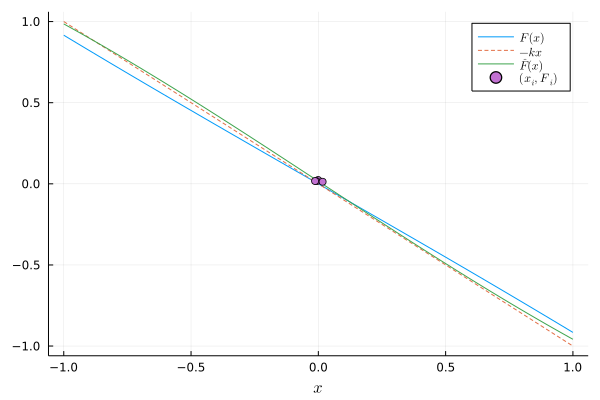

In [248]:
fig = plot(X,F.(X,Ref(ℳ)),xlabel=L"x",label=L"F(x)")
fig = plot!(X,-k*X,style=:dash,label=L"-kx")
fig = plot!(X,F̂.(X),label=L"\hat F(x)")
fig = scatter!(xi,Fi,label=L"(x_i,F_i)")